In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables

Base.prepare(engine, reflect = True)



/var/folders/qt/x3npm1257yl6mmvpxswgk46h0000gn/T/ipykernel_2539/1307152959.py:7: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect = True)


In [6]:
# View all of the classes that automap found

Base.classes.keys()


['station', 'measurement']

In [7]:
# Save references to each table

Measurement_ref = Base.classes.measurement

Station_ref = Base.classes.station


In [8]:
#Show the columns in the measurement table

print(Measurement_ref.__table__.columns.keys())

['id', 'station', 'date', 'prcp', 'tobs']


In [9]:
#Show the columns in the station table

print(Station_ref.__table__.columns.keys())

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


In [10]:
# Create our session (link) from Python to the DB

session = Session(engine)


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.

most_recent_date = session.query(Measurement_ref.date).order_by(Measurement_ref.date.desc()).first()

print(f"Most recent date in data set is {most_recent_date}")

Most recent date in data set is ('2017-08-23',)


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

ending_date = dt.datetime(2017, 8, 23)
beginning_date = ending_date - dt.timedelta(days=365)

# Calculate the date one year from the last date in data set.

print(f"Beginning date in data set is {beginning_date}")

Beginning date in data set is 2016-08-23 00:00:00


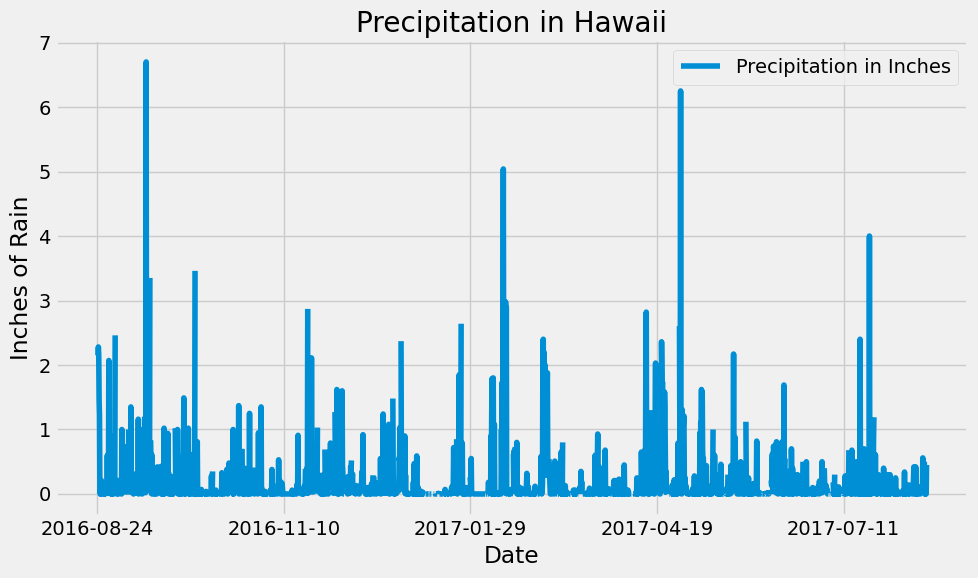

In [13]:
# Perform a query to retrieve the date and precipitation scores

precipitation_results = session.query(Measurement_ref.date, Measurement_ref.prcp).\
    filter(Measurement_ref.date >= beginning_date)

# Save the query results as a Pandas DataFrame. Explicitly set the column names

precipitation_df = pd.DataFrame(precipitation_results, columns = ["Date", "Precipitation in Inches"])

# Sort the dataframe by date

precipitation_df = precipitation_df.sort_values("Date")

# Use Pandas Plotting with Matplotlib to plot the data

precipitation_df.plot (x = "Date", y = "Precipitation in Inches", figsize = (10, 6), title = "Precipitation in Hawaii")
plt.ylabel("Inches of Rain")
plt.xlabel("Date")
# plt.legentd(["Precipitation"])
plt.tight_layout()
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data

Hawaii_precipitation_summary = precipitation_df.describe()
print(Hawaii_precipitation_summary)

       Precipitation in Inches
count              2015.000000
mean                  0.176462
std                   0.460288
min                   0.000000
25%                   0.000000
50%                   0.020000
75%                   0.130000
max                   6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset

total_stations = session.query(func.count(Station_ref.station)).all()[0][0]

print(f"Total number of stations in the dataset is {total_stations}")

Total number of stations in the dataset is 9


In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

most_active_stations = session.query(Measurement_ref.station, func.count(Measurement_ref.id)).\
    group_by(Measurement_ref.station).order_by(func.count(Measurement_ref.id).desc()).all()

print(f"Most active stations are {most_active_stations}")

Most active stations are [('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


most_active_lowest_temp = session.query(func.min(Measurement_ref.tobs)).filter(Measurement_ref.station == "USC00519281").all()[0][0]
most_active_highest_temp = session.query(func.max(Measurement_ref.tobs)).filter(Measurement_ref.station == "USC00519281").all()[0][0]
most_active_avg_temp = session.query(func.avg(Measurement_ref.tobs)).filter(Measurement_ref.station == "USC00519281").all()[0][0]

print(f"Lowest temperature for most active station is {most_active_lowest_temp} degrees.")
print(f"Highest temperature for most active station is {most_active_highest_temp} degrees.")
print(f"Average temperature for most active station is {most_active_avg_temp} degrees.")

Lowest temperature for most active station is 54.0 degrees.
Highest temperature for most active station is 85.0 degrees.
Average temperature for most active station is 71.66378066378067 degrees.


In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_12_months_temp = session.query(Measurement_ref.tobs).filter(Measurement_ref.station == "USC00519281")\
    .filter(Measurement_ref.date >= beginning_date).all()   

most_active_12_months_temp_df = pd.DataFrame(most_active_12_months_temp, columns = ["tobs"])

most_active_12_months_temp_df.rename(columns={"tobs": "Temperature in Degrees F"}, inplace=True)

most_active_12_months_temp_df.head(12)

,Temperature in Degrees F
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0
5,78.0
6,77.0
7,78.0
8,80.0
9,80.0


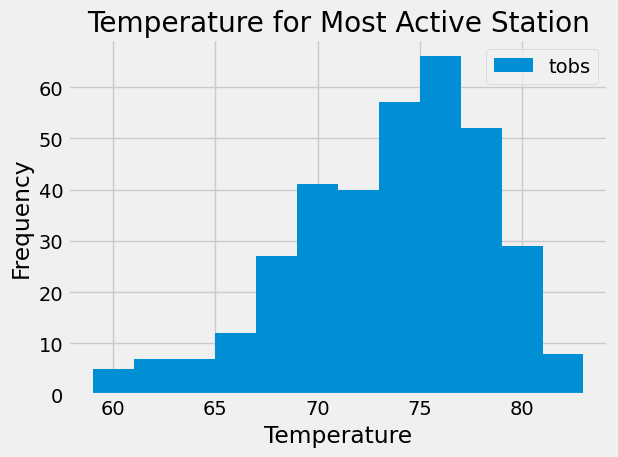

In [19]:
# Plot the results as a histogram

most_active_12_months_temp_df.plot.hist(bins = 12, title = "Temperature for Most Active Station")
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.legend(["tobs"])
plt.tight_layout()
plt.show()

# Close Session

In [20]:
# Close Session
session.close()